In [30]:
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from numpy import random
from sklearn.model_selection import train_test_split
import os
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import r2_score
from random import seed
from random import randrange
import timeit
import tensorflow as tf
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../../Data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../../Data/ecg_data_with_labels.csv
../../Data/SNOMED_mappings_scored.csv
../../Data/SNOMED_mappings_unscored.csv
../../Data/weights.csv


In [32]:
import os
for dirname, _, filenames in os.walk('../'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../CVplot\boxplot.ipynb
../CVplot\.ipynb_checkpoints\boxplot-checkpoint.ipynb
../Models\confmatrix_weights.png
../Models\diagnoses_distribution.png
../Models\Encder_FCN+rule_PhysioNetChallenge2020.ipynb
../Models\Encder_FCN_MLP+rule_PhysioNetChallenge2020.ipynb
../Models\EncoderPhysioNetChallenge2020.ipynb
../Models\Encoder_MLP_PhysioNetChallenge2020.ipynb
../Models\EnsembleModel12lead.ipynb
../Models\EnsembleModel2lead.ipynb
../Models\FCNPhysioNetChallenge2020.ipynb
../Models\FCN_MLP_PhysioNetChallenge2020.ipynb
../Models\fordeling.png
../Models\scoring_alg.py
../Models\.ipynb_checkpoints\EnsembleModel12lead-checkpoint.ipynb
../Models\.ipynb_checkpoints\EnsembleModel2lead-checkpoint.ipynb
../Models\__pycache__\scoring_alg.cpython-37.pyc


In [33]:
FeatureNames = ['gender','age','R HR STD','R HR median','R HR min', 'R HR max','R HR mean','RMSSD','R amp II std','R amp II min','R amp II min_2', 'R amp leads I', 'R amp leads II', 'R amp lead III', 
                'R amp lead aVR','R amp lead aVL','R amp lead aVF', 'R amp V1','R amp V2','R amp V3','R amp V4','R amp V5','R amp V6','p_offset_std','p_offset_median','p_offset_min','p_offset_max',
                'mean_p_offset','p_onsets_std','p_onsets_median','p_onsets_min','p_onsets_max','mean_p_onsets','ECG_baseline','p_rate_std','p_rate_median','p_rate_min','p_rate_max','mean_p_rate', 
                'P amp leads I', 'P amp leads II', 'P amp lead III', 'P amp lead aVR','P amp lead aVL','P amp lead aVF', 'P amp V1','P amp V2','P amp V3','P amp V4','P amp V5','P amp V6','q_rate_std',
                'q_rate_median','q_rate_min','q_rate_max','mean_q_rate','Q amp leads I', 'Q amp leads II', 'Q amp lead III', 'Q amp lead aVR','Q amp lead aVL','Q amp lead aVF', 'Q amp V1','Q amp V2',
                'Q amp V3','Q amp V4','Q amp V5','Q amp V6','s_rate_std','s_rate_median','s_rate_min','s_rate_max','mean_s_rate','S amp leads I', 'S amp leads II', 'S amp lead III', 'S amp lead aVR',
                'S amp lead aVL','S amp lead aVF', 'S amp V1','S amp V2','S amp V3','S amp V4','S amp V5','S amp V6','t_rate_std','t_rate_median','t_rate_min','t_rate_max','mean_t_rate',
                'T amp leads I', 'T amp leads II', 'T amp lead III', 'T amp lead aVR','T amp lead aVL','T amp lead aVF', 'T amp V1','T amp V2','T amp V3','T amp V4','T amp V5','T amp V6','t_offset_std',
                't_offset_median','t_offset_min','t_offset_max','mean_t_offset','t_onsets_std','t_onsets_median','t_onsets_min','t_onsets_max','mean_t_onsets','labels']

In [34]:
%load_ext autoreload
%autoreload 
%reload_ext autoreload
#import utility_script_multi_sklearn as us

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import scoring_alg as sa

In [37]:
SNOMED_scored=pd.read_csv("../../Data/SNOMED_mappings_scored.csv", sep=";")
SNOMED_unscored=pd.read_csv("../../Data/SNOMED_mappings_unscored.csv", sep=";")

In [38]:
data = pd.read_csv('../../Data/ecg_data_with_labels.csv')

In [39]:
data = data.iloc[:,1:]

In [40]:
data.columns = FeatureNames

In [41]:
data = data.drop(columns=['R amp leads I','R amp lead III', 'R amp lead aVR','R amp lead aVL','R amp lead aVF', 'R amp V1','R amp V2','R amp V3','R amp V4','R amp V6','P amp leads I','P amp lead III',
                   'P amp lead aVR','P amp lead aVL','P amp lead aVF', 'P amp V1','P amp V2','P amp V3','P amp V4','P amp V6','Q amp leads I','Q amp lead III', 'Q amp lead aVR','Q amp lead aVL',
                   'Q amp lead aVF', 'Q amp V1','Q amp V2','Q amp V3','Q amp V4','Q amp V6','S amp leads I','S amp lead III', 'S amp lead aVR','S amp lead aVL','S amp lead aVF', 'S amp V1',
                   'S amp V2','S amp V3','S amp V4','S amp V6','T amp leads I','T amp lead III', 'T amp lead aVR','T amp lead aVL','T amp lead aVF', 'T amp V1','T amp V2','T amp V3','T amp V4','T amp V6'])

In [42]:
conf_weights = pd.read_csv("../../Data/weights.csv", sep=",", header= 0, index_col=0 )

In [43]:
data.head()

,gender,age,R HR STD,R HR median,R HR min,R HR max,R HR mean,RMSSD,R amp II std,R amp II min,...,t_offset_median,t_offset_min,t_offset_max,mean_t_offset,t_onsets_std,t_onsets_median,t_onsets_min,t_onsets_max,mean_t_onsets,labels
0,0.0,74.0,0.818758,100.334448,99.009901,102.040816,100.537248,10108.408537,0.017732,0.005,...,100.334448,97.087379,105.263158,100.470283,14.954241,100.334448,83.102493,128.205128,102.729465,59118001
1,0.0,49.0,1.760567,76.923583,76.142132,81.300813,77.742365,6046.974958,0.010598,0.509,...,77.519380,75.376884,81.081081,77.848763,2.431188,77.720207,74.812968,82.872928,77.885993,426783006
2,0.0,81.0,37.708984,141.308685,31.120332,185.185185,131.051603,18596.490035,0.083807,0.727,...,144.927536,30.895984,227.272727,137.312455,58.608281,136.986301,31.023785,272.727273,139.162091,164889003
3,0.0,45.0,25.252184,109.090909,70.754717,153.846154,110.019668,12742.000091,0.182643,0.757,...,91.743119,72.639225,285.714286,120.996071,61.174821,93.167702,68.181818,285.714286,123.129987,164889003
4,0.0,53.0,6.227148,119.521912,101.694915,144.230769,120.016109,14442.643773,0.182657,1.633,...,118.812347,84.745763,267.857143,128.928710,47.516386,120.000000,80.862534,256.410256,133.257833,164884008


In [44]:
print(np.where(data.iloc[:,:-1].isna()))
print(data.index[np.isinf(data.iloc[:,:-1]).any(1)])
#print(data.columns.to_series()[np.isinf(data.iloc[:,:-1]).any()])

(array([   10,    10,    10, ..., 42715, 42715, 42715], dtype=int64), array([45, 46, 49, ..., 45, 52, 57], dtype=int64))
Int64Index([  632,  3697,  3939,  4014,  4518,  5058,  5679,  5891,  6062,
             8216, 13699, 13724, 19728, 20086, 23641, 23989, 24402, 26278,
            27813, 28736, 29211, 29417, 29893, 32200, 34761, 36265, 37771,
            38037, 38738, 38760, 38789, 38790, 38793, 40416, 42518, 42715],
           dtype='int64')


In [45]:
data = data.dropna()

In [46]:
data.shape

(42574, 63)

About 150 ECG-recordings removed

In [47]:
print(np.where(data.iloc[:,1:-1].isna()))
print(data.index[np.isinf(data.iloc[:,1:-1]).any(1)])
#print(data.columns.to_series()[np.isinf(data.iloc[:,1:-1]).any()])

(array([], dtype=int64), array([], dtype=int64))
Int64Index([], dtype='int64')


In [48]:
y_data = data['labels']

In [49]:
X_data = data.iloc[:,:-1]

In [50]:
X_data.head()

,gender,age,R HR STD,R HR median,R HR min,R HR max,R HR mean,RMSSD,R amp II std,R amp II min,...,t_offset_std,t_offset_median,t_offset_min,t_offset_max,mean_t_offset,t_onsets_std,t_onsets_median,t_onsets_min,t_onsets_max,mean_t_onsets
0,0.0,74.0,0.818758,100.334448,99.009901,102.040816,100.537248,10108.408537,0.017732,0.005,...,1.848068,100.334448,97.087379,105.263158,100.470283,14.954241,100.334448,83.102493,128.205128,102.729465
1,0.0,49.0,1.760567,76.923583,76.142132,81.300813,77.742365,6046.974958,0.010598,0.509,...,2.080792,77.519380,75.376884,81.081081,77.848763,2.431188,77.720207,74.812968,82.872928,77.885993
2,0.0,81.0,37.708984,141.308685,31.120332,185.185185,131.051603,18596.490035,0.083807,0.727,...,52.999777,144.927536,30.895984,227.272727,137.312455,58.608281,136.986301,31.023785,272.727273,139.162091
3,0.0,45.0,25.252184,109.090909,70.754717,153.846154,110.019668,12742.000091,0.182643,0.757,...,56.992963,91.743119,72.639225,285.714286,120.996071,61.174821,93.167702,68.181818,285.714286,123.129987
4,0.0,53.0,6.227148,119.521912,101.694915,144.230769,120.016109,14442.643773,0.182657,1.633,...,38.864796,118.812347,84.745763,267.857143,128.928710,47.516386,120.000000,80.862534,256.410256,133.257833


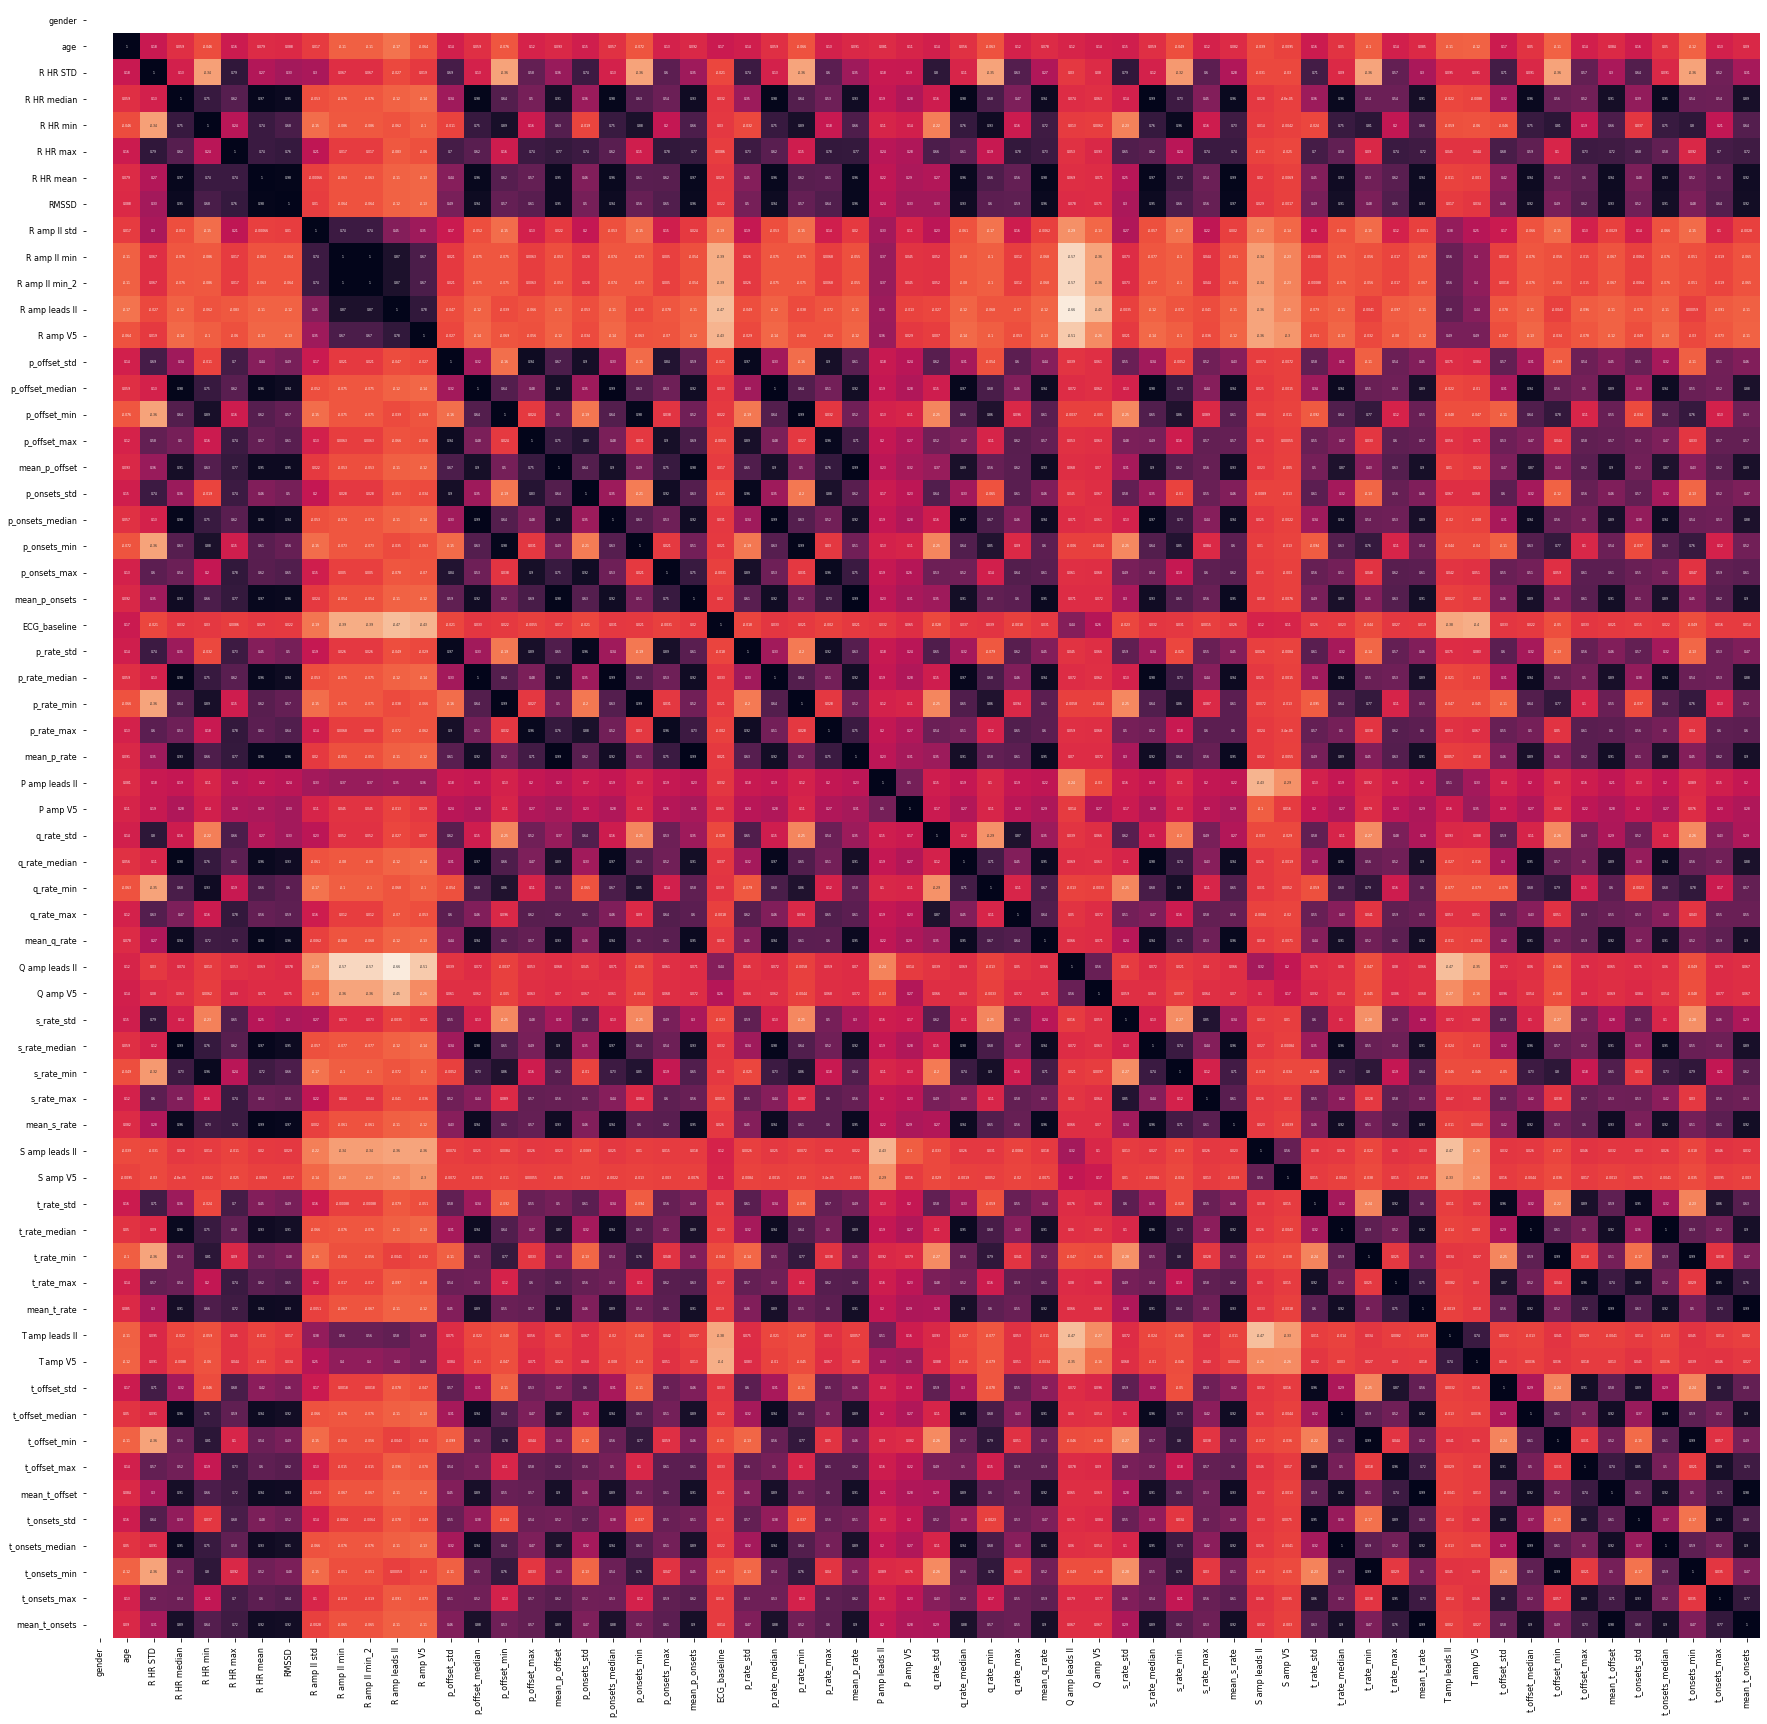

In [51]:
import seaborn as sns
plt.figure(figsize=(30,30))
cor = data.corr()
sns.heatmap(cor, cmap="rocket_r", annot=True,cbar=False, annot_kws={"size": 3})
plt.show()

In [52]:
def making_undef_class(labels):
    df_labels = pd.DataFrame(labels)
    for i in range(len(SNOMED_unscored.iloc[0:,1])):
        df_labels.replace(to_replace=str(SNOMED_unscored.iloc[i,1]), inplace=True ,value="undefined class", regex=True)
    return df_labels

  
df_y = making_undef_class(y_data)

In [53]:
y_data.unique()

array(['59118001', '426783006', '164889003', ..., '368009,427084000',
       '698247007,74390002', '164895002,164896001,164865005,164889003'],
      dtype=object)

In [54]:
from sklearn.preprocessing import MultiLabelBinarizer
one_hot = MultiLabelBinarizer()
y=one_hot.fit_transform(df_y['labels'].str.split(pat=','))
print(one_hot.classes_)
print("classes: {}".format(y.shape[1]))

['10370003' '111975006' '164889003' '164890007' '164909002' '164917005'
 '164934002' '164947007' '17338001' '251146004' '270492004' '284470004'
 '39732003' '426177001' '426627000' '426783006' '427084000' '427172004'
 '427393009' '445118002' '47665007' '59118001' '59931005' '63593006'
 '698252002' '713426002' '713427006' 'undefined class']
classes: 28


In [55]:
y = np.delete(y, -1, axis=1)

In [56]:
norsk_liste = ['pacing-rytme', 'forlenget qt-intervall', 'atrieflimmer','atrieflutter','venstre grenblokk','unormal Q-bølge','unormal T-bølge','forlenget PR-intervall', 'ventrikulære premature slag','lav QRS-spenning','1.grads AV-blokk','prematur atriell kontraksjon',
               'venstre akse avvik','sinusbradykardi','bradykardi','sinus rytme', 'sinus takykardi', 'prematur ventrikulær kontraksjon','sinusarytmi','venstre fremre fascikulærblokk','høyre akse avvik','høyre grenblokk','invertert T-bølge','supraventrikulære premature slag',
               'uspesifikk intraventrikulær ledningsforstyrrelse','ufullstendig høyre grenblokk','komplett høyre grenblokk']

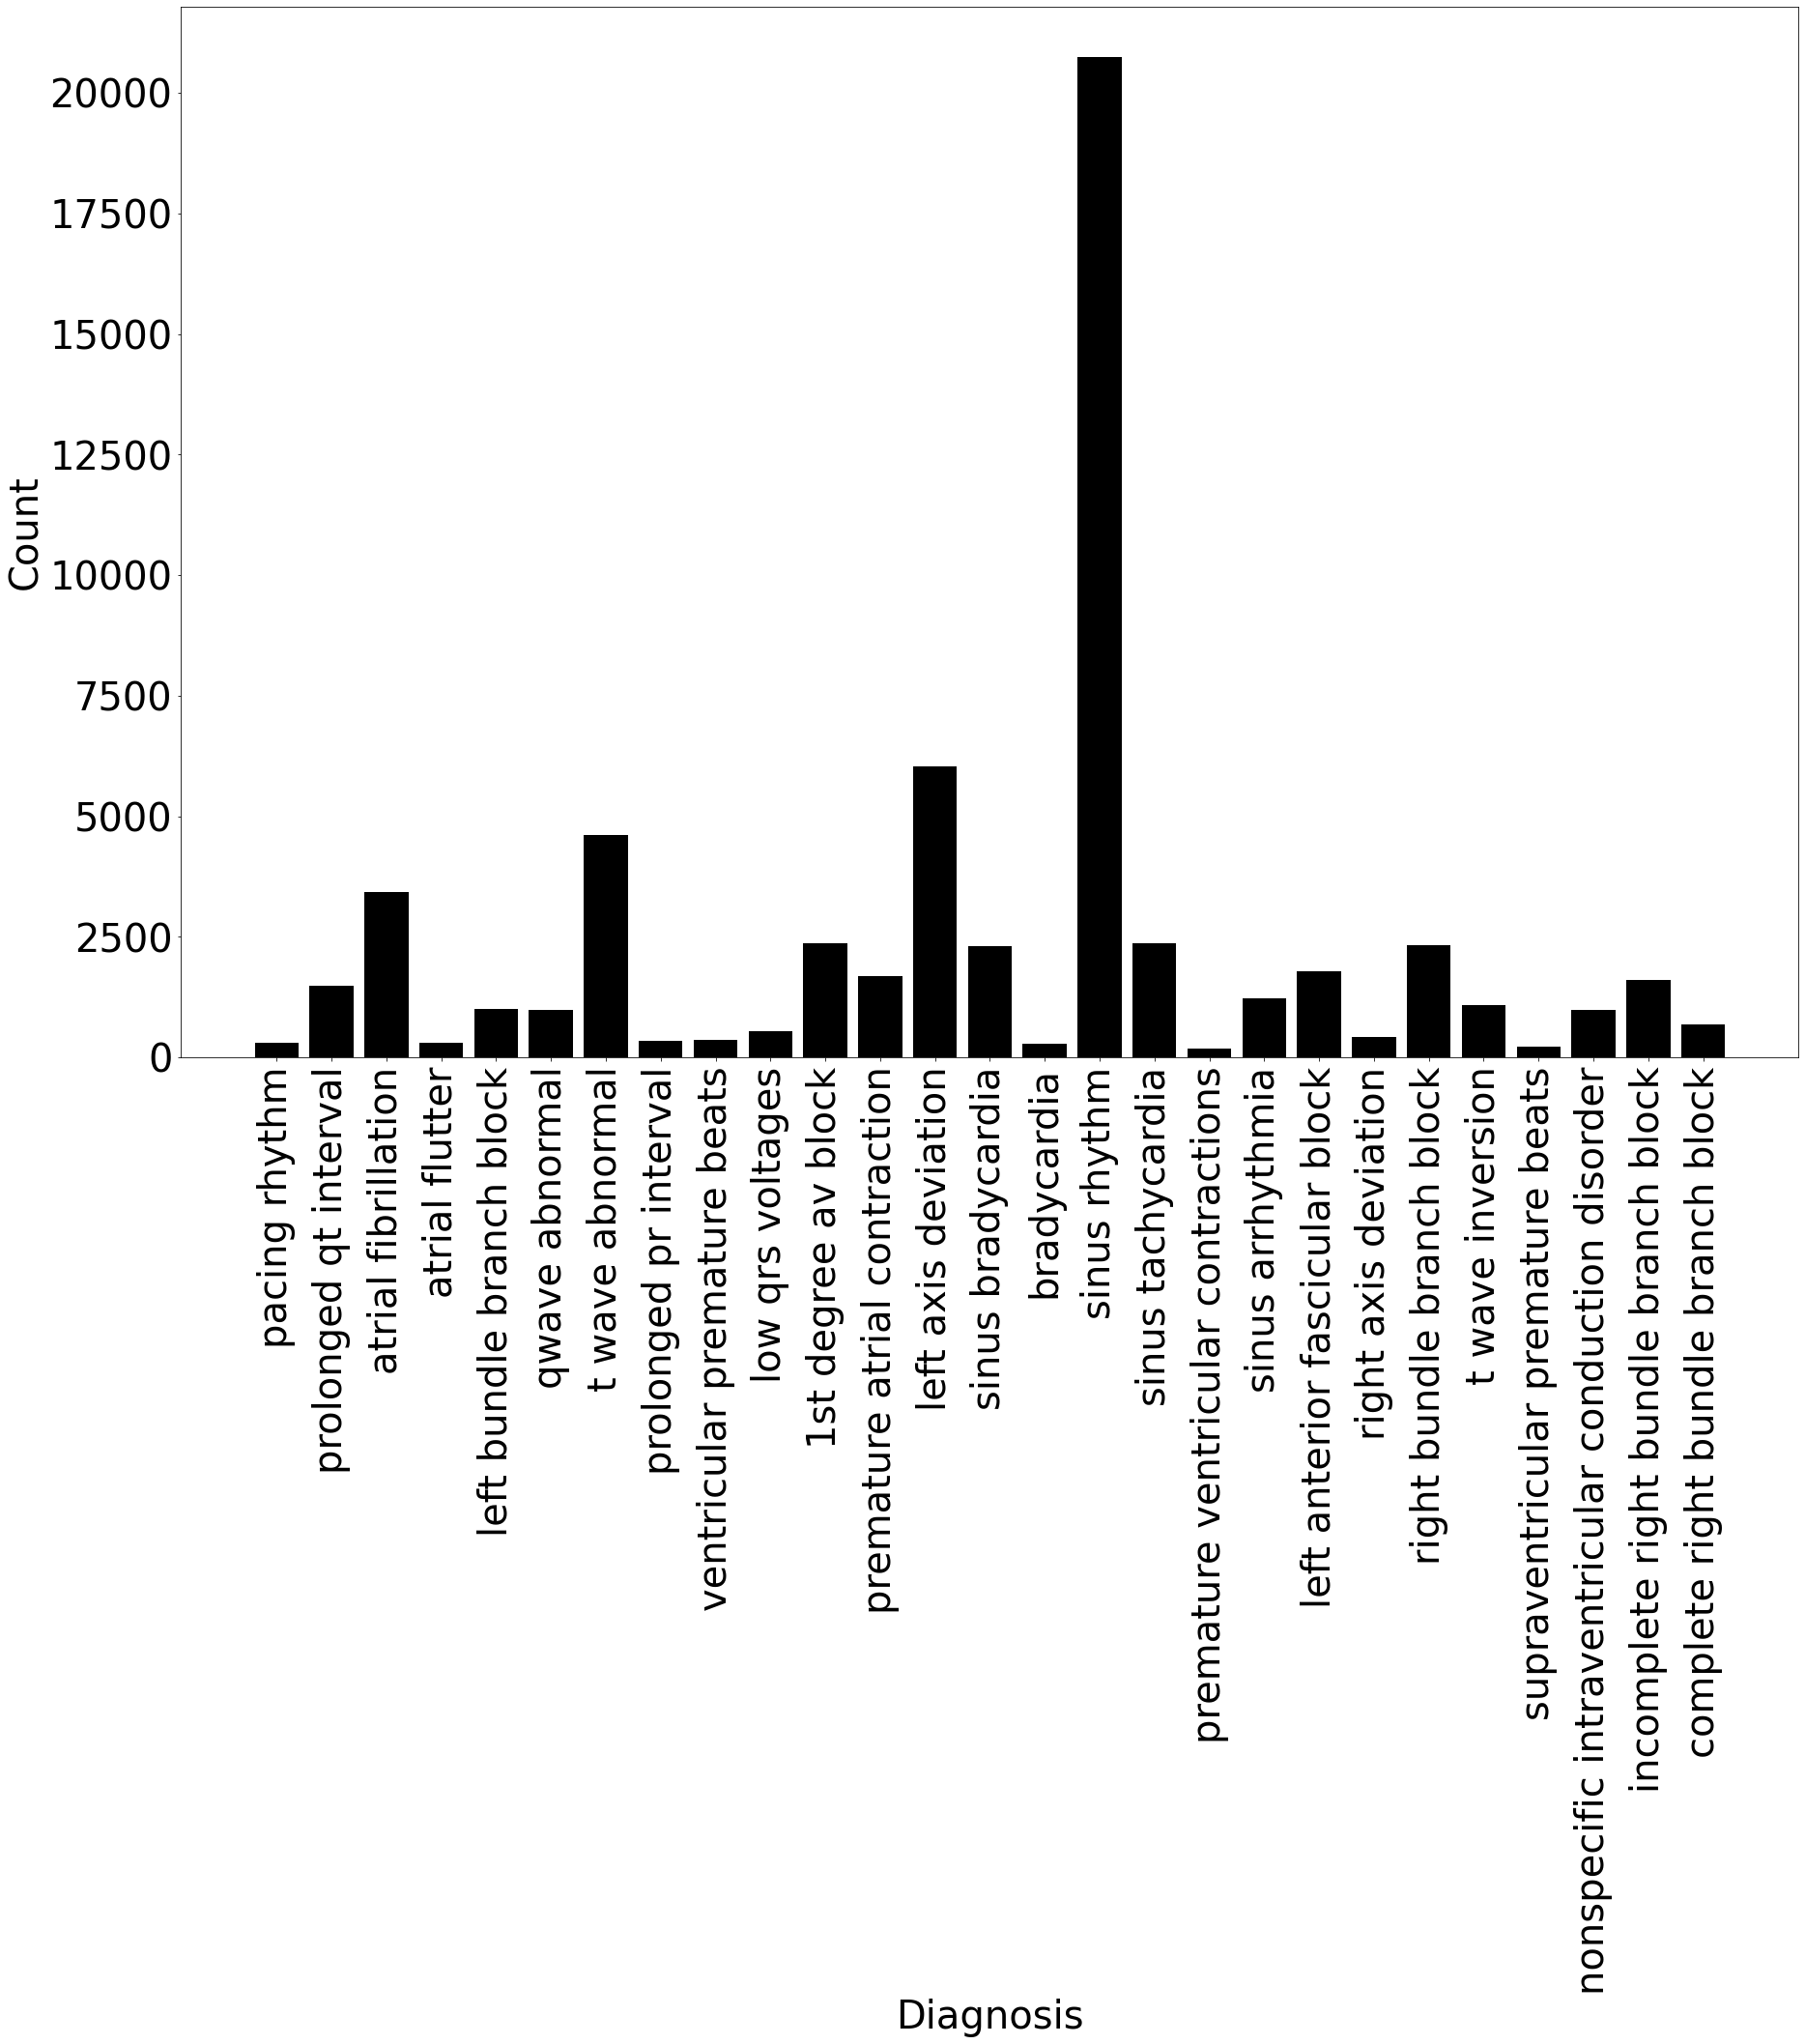

In [57]:
sa.plot_classes(one_hot.classes_[0:-1],SNOMED_scored, y)

In [58]:
#@title Transform our One Hot encoded multilabel output to a new type of label where all can be represented by a number:
from sklearn.preprocessing import LabelEncoder

def get_new_labels(y):
    y_new = LabelEncoder().fit_transform([''.join(str(l)) for l in y])
    return y_new

y_temp_new = get_new_labels(y)
print("Total number of unique combinations of diagnosis: {}".format(len(np.unique(y_temp_new))))

Total number of unique combinations of diagnosis: 1396


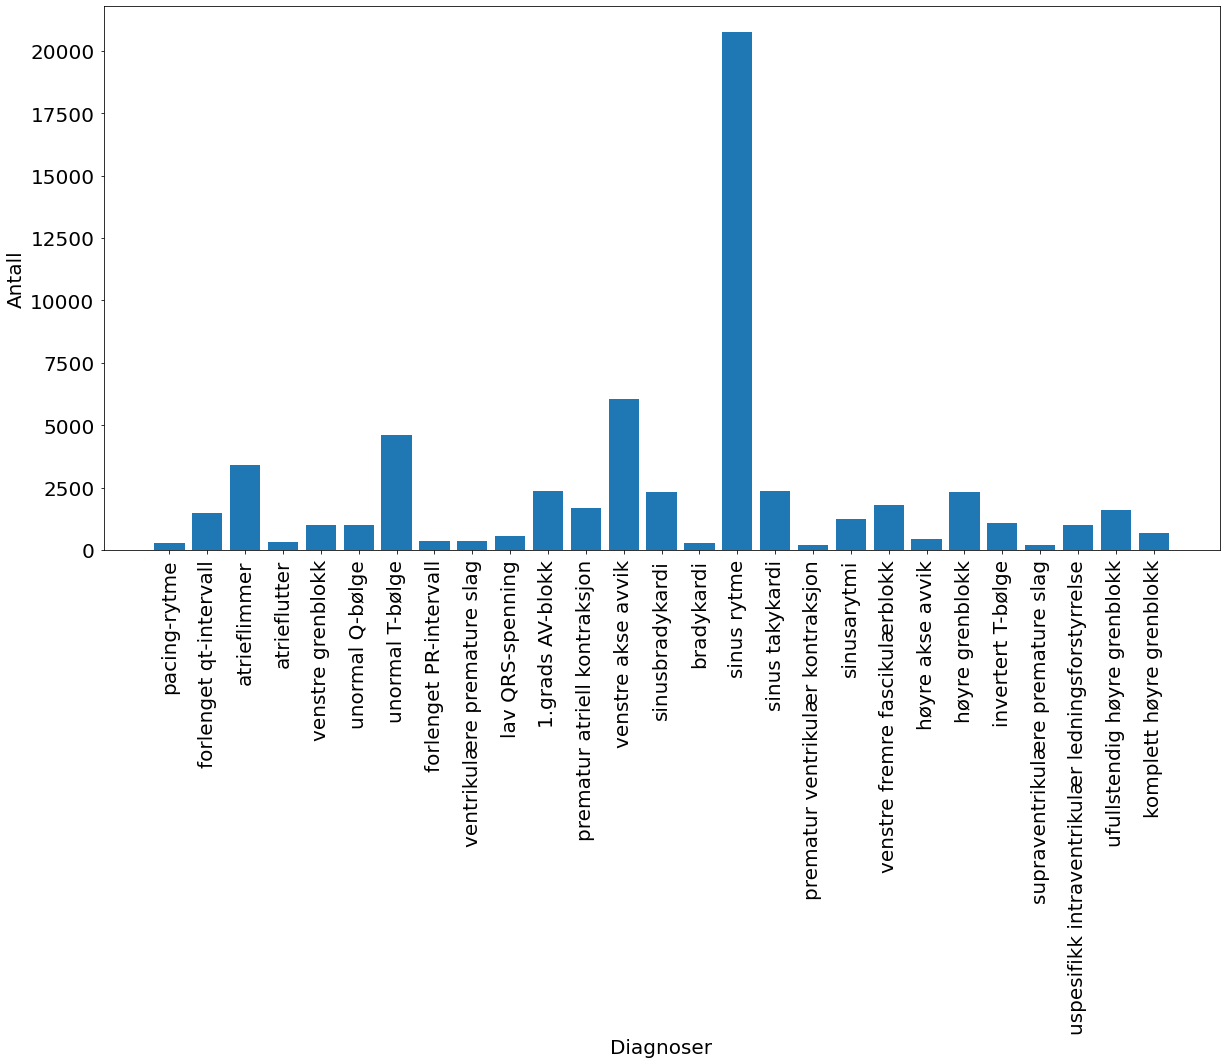

In [59]:
sa.plot_classes_2(one_hot.classes_[0:-1],y,SNOMED_scored,norsk_liste)

In [60]:
one_hot.classes_[0:-1][26]

'complete right bundle branch block'

In [61]:
#@title Transform our One Hot encoded multilabel output to a new type of label where all can be represented by a number:
from sklearn.preprocessing import LabelEncoder

def get_new_labels(y):
    y_new = LabelEncoder().fit_transform([''.join(str(l)) for l in y])
    return y_new

y_new = get_new_labels(y)
print("Total number of unique combinations of diagnosis in train set: {}".format(len(np.unique(y_new))))

Total number of unique combinations of diagnosis in train set: 1396


In [62]:
#@title K-fold, 10 splits, Shuffle=True and random_state = 42. The distribution of Training and Val data in each fold is now:
from sklearn.model_selection import StratifiedKFold
folds = list(StratifiedKFold(n_splits=10, shuffle=True, random_state=42).split(y,y_new))
print("Training split: {}".format(len(folds[0][0])))
print("Validation split: {}".format(len(folds[0][1])))

Training split: 38316
Validation split: 4258


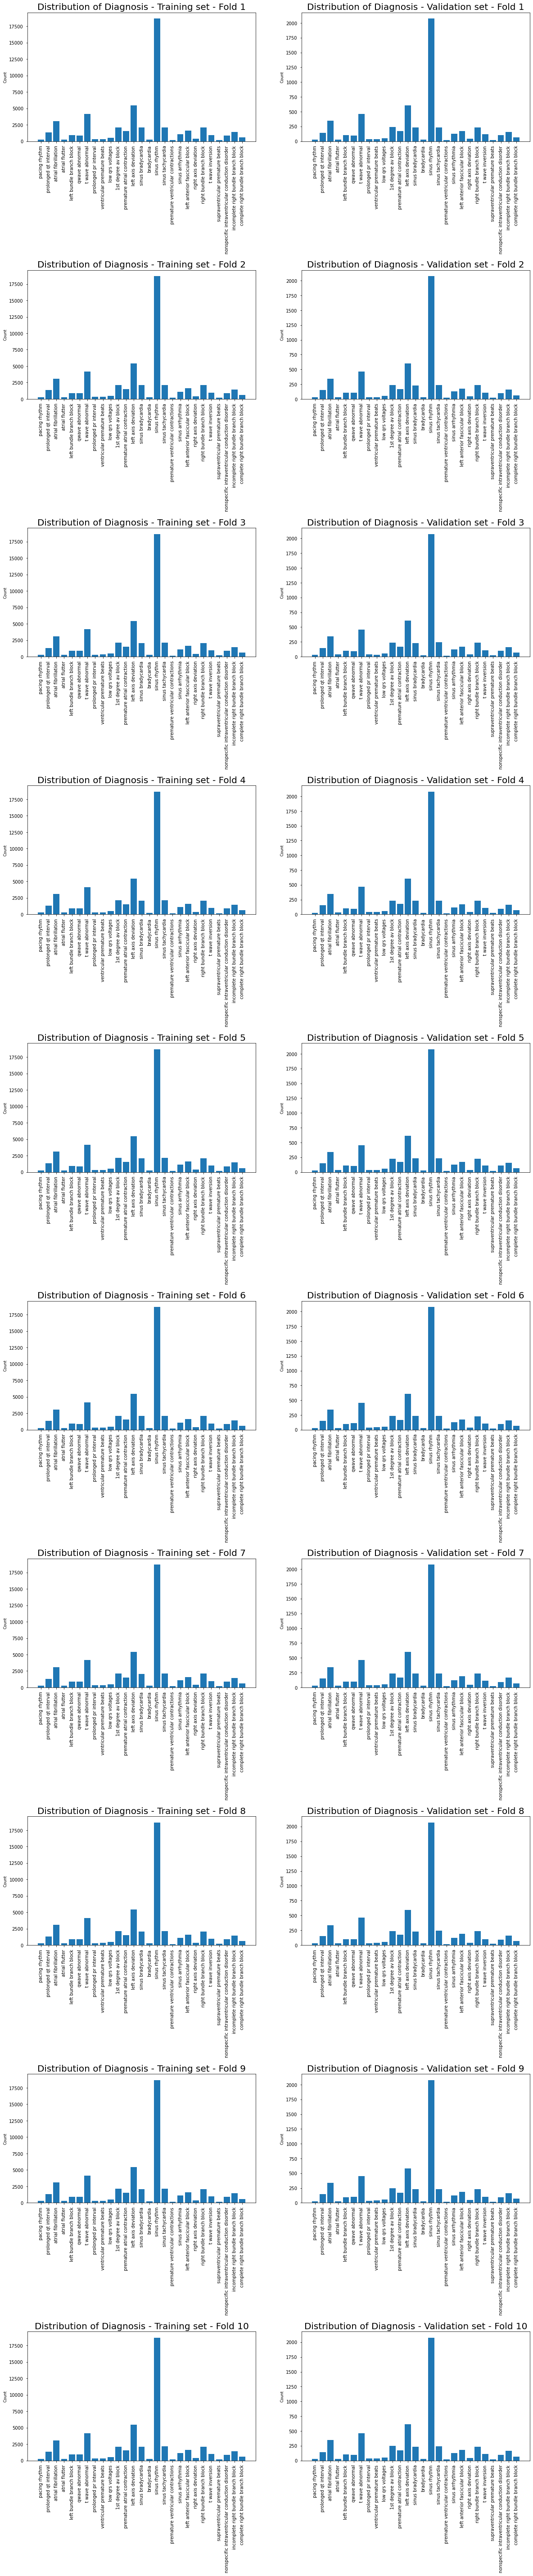

In [63]:
#@title The distribution of diagnosis in each Fold:
X_axis_labels=one_hot.classes_[0:-1]
plt.figure(figsize=(20,100))
h=1
for i in range(len(folds)):
    plt.subplot(10,2,h)
    plt.subplots_adjust(hspace=1.0)
    plt.bar(x= X_axis_labels, height=y[folds[i][0]].sum(axis=0))
    plt.title("Distribution of Diagnosis - Training set - Fold {}".format(i+1) ,fontsize="20", color = "black")
    plt.tick_params(axis="both", colors = "black")
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize = 10)
    #plt.xlabel("Diagnosis", color = "white")
    plt.ylabel("Count", color = "black")
    h=h+1
    plt.subplot(10,2,h)
    plt.subplots_adjust(hspace=1.0)
    plt.bar(x= X_axis_labels, height=y[folds[i][1]].sum(axis=0))
    plt.title("Distribution of Diagnosis - Validation set - Fold {}".format(i+1) ,fontsize="20", color = "black")
    plt.tick_params(axis="both", colors = "black")
    #plt.xlabel("Diagnosis", color = "white")
    plt.ylabel("Count", color = "black")
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize = 10)
    h=h+1

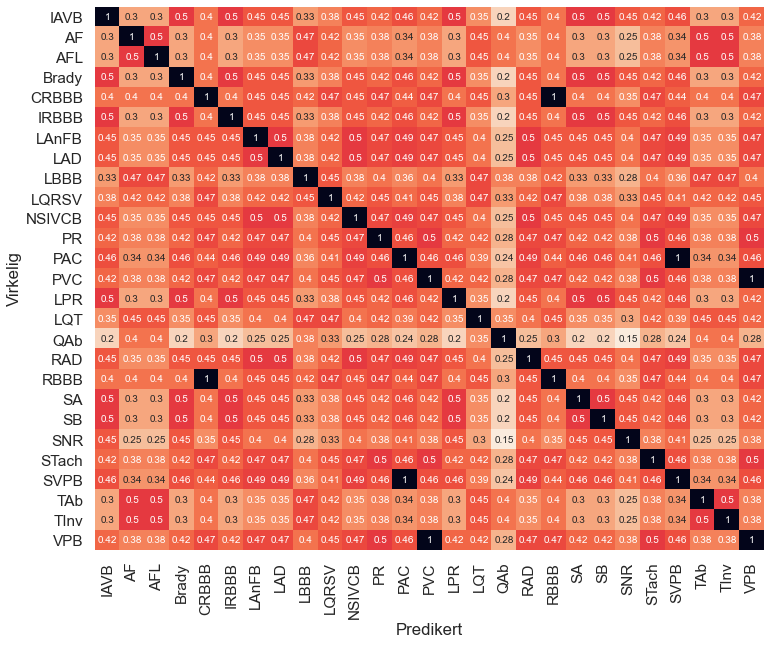

In [64]:
import seaborn as sns
conf_weights.columns = SNOMED_scored.iloc[:,0]
conf_weights.index = SNOMED_scored.iloc[:,0]

conf_weights = pd.DataFrame(conf_weights, columns=SNOMED_scored.iloc[:,0], index = SNOMED_scored.iloc[:,0])

conf_weights.columns=SNOMED_scored.iloc[:,2]
conf_weights.index = SNOMED_scored.iloc[:,2]
conf_weights.index.name = 'Virkelig'
conf_weights.columns.name = 'Predikert'

plt.figure(figsize = (12,10))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_weights, cmap="rocket_r", annot=True,cbar=False, annot_kws={"size": 10})# font size
plt.savefig("./confmatrix_weights.png",dpi=200)

In [65]:
my_cluster = []
for i in range(len(y.T)):
    my_cluster.append(np.unique(np.where(y[np.where(y.T[i]==1)])[1]))

In [66]:
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.ensemble import LabelSpacePartitioningClassifier
from skmultilearn.cluster import FixedLabelSpaceClusterer
from sklearn.ensemble import RandomForestClassifier

In [67]:
val_res = np.zeros(shape=(5,10))
training_res = np.zeros(shape=(5,10))
j = 0

for train_index, val_index in folds:
    
    X_train, X_val = np.asarray(X_data)[train_index], np.asarray(X_data)[val_index]
    y_train, y_val = y[train_index], y[val_index]


    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    print("Making a cluster")
    my_cluster = []
    for i in range(len(y_train.T)):
        my_cluster.append(np.unique(np.where(y_train[np.where(y_train.T[i]==1)])[1]))
    print("Making the model")
    classifier = LabelSpacePartitioningClassifier(
        classifier = ClassifierChain(
            classifier= RandomForestClassifier(n_jobs=-1,n_estimators=5, verbose=0),
            require_dense = [False, True]
        ),
        require_dense = [True, True],
        clusterer = FixedLabelSpaceClusterer(clusters=my_cluster)
    )

    classifier.fit(X_train_scaled,y_train)
    y_pred_val = classifier.predict(X_val_scaled)
    y_pred_train = classifier.predict(X_train_scaled)

    y_pred_val = y_pred_val.todense()
    y_pred_val = np.asarray(y_pred_val)

    y_pred_train = y_pred_train.todense()
    y_pred_train = np.asarray(y_pred_train)

    val_res[0,j] = us.compute_beta_measures(y_val,y_pred_val,2)[0]
    val_res[1,j] = us.compute_beta_measures(y_val,y_pred_val,2)[1]
    val_res[2,j] = us.compute_f_measure(y_val,y_pred_val)
    val_res[3,j] = us.compute_accuracy(y_val,y_pred_val)
    val_res[4,j] = us.compute_challenge_metric_for_opt(y_val,y_pred_val)
    training_res[0,j] = us.compute_beta_measures(y_train,y_pred_train,2)[0]
    training_res[1,j] = us.compute_beta_measures(y_train,y_pred_train,2)[1]
    training_res[2,j] = us.compute_f_measure(y_train,y_pred_train)
    training_res[3,j] = us.compute_accuracy(y_train,y_pred_train)
    training_res[4,j] = us.compute_challenge_metric_for_opt(y_train,y_pred_train)
    j = j+1



    print("{}-fold cross val:".format(j))
    print("F2-score:",us.compute_beta_measures(y_val,y_pred_val,2)[0])
    print("G2-score:",us.compute_beta_measures(y_val,y_pred_val,2)[1])
    print("F-measure:",us.compute_f_measure(y_val,y_pred_val))
    print("Accuracy:",us.compute_accuracy(y_val,y_pred_val))
    print("Challenge prediction:", us.compute_challenge_metric_for_opt(y_val,y_pred_val))
    print("Challenge prediction (train data):", us.compute_challenge_metric_for_opt(y_train,y_pred_train))
    
validerings_resultat = pd.DataFrame(val_res)
trenings_resultat = pd.DataFrame(training_res)
validerings_resultat.to_csv("valideringsresultat_forest_chain_cluster_2leads.csv")
trenings_resultat.to_csv("treningsresultat_forest_chain_cluster_2leads.csv")

Making a cluster
Making the model


KeyboardInterrupt: 